# TMDB Movie Dataset EDA, Modeling, and Recommender System


In [1]:
# Disable warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## 1. Data Loading and Gain Info


In [3]:
df_credits = pd.read_csv("Dataset/tmdb_5000_credits.csv")
df_movies = pd.read_csv("Dataset/tmdb_5000_movies.csv")

In [4]:
df_credits.head().T

,0,1,2,3,4
movie_id,19995,285,206647,49026,49529
title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
cast,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."
crew,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [5]:
df_movies.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
id,19995,285,206647,49026,49529
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.437577,139.082615,107.376788,112.31295,43.926995
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]"


Combine the data from the following files:

- tmdb_5000_credits.csv
- tmdb_5000_movies.csv

The dataset is from Kaggle: https://www.kaggle.com/tmdb/tmdb-movie-metadata

Join the two datasets on the 'id' column.


In [6]:
# Check for Joining Key
(df_credits.movie_id != df_movies.id).any().sum()
# 0 means we can join the two dataframes on movie_id

0

In [7]:
df = df_movies.merge(
    df_credits, left_on="id", right_on="movie_id", suffixes=("_movies", "_credits")
)
df.drop(["id"], axis=1, inplace=True)
df.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.437577,139.082615,107.376788,112.31295,43.926995
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]"
production_countries,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""iso_3166_1"": ""US"", ""name"": ""United States o..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   original_title        4803 non-null   object 
 6   overview              4800 non-null   object 
 7   popularity            4803 non-null   float64
 8   production_companies  4803 non-null   object 
 9   production_countries  4803 non-null   object 
 10  release_date          4802 non-null   object 
 11  revenue               4803 non-null   int64  
 12  runtime               4801 non-null   float64
 13  spoken_languages      4803 non-null   object 
 14  status                4803 non-null   object 
 15  tagline              

In [9]:
# Drop columns that are not useful
df.drop(["homepage", "status", "production_countries"], axis=1, inplace=True)

Handle the missing values.


In [10]:
# Replace overview and tagline NaN with empty string
df["overview"].fillna("", inplace=True)
df["tagline"].fillna("", inplace=True)
# Replace runtime NaN with median
df["runtime"].fillna(df["runtime"].median(), inplace=True)
# Replace release_date NaN with 1st January 2000
df["release_date"].fillna("2000-01-01", inplace=True)
# Find missing values
df.isnull().sum()

budget                  0
genres                  0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
tagline                 0
title_movies            0
vote_average            0
vote_count              0
movie_id                0
title_credits           0
cast                    0
crew                    0
dtype: int64

## 2. Data cleaning and Preprocessing


Some features are in json format, we need to convert them to a list of strings.


In [11]:
# Convert JSON columns to list
import json


def convert_json_to_list(df, columns):
    for column in columns:
        df[column] = df[column].apply(json.loads)
    return df


df = convert_json_to_list(
    df,
    ["genres", "keywords", "production_companies", "spoken_languages", "cast", "crew"],
)

df.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
keywords,"[{'id': 1463, 'name': 'culture clash'}, {'id':...","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.437577,139.082615,107.376788,112.31295,43.926995
production_companies,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'name': 'Walt Disney Pictures', 'id': 2}]"
release_date,2009-12-10,2007-05-19,2015-10-26,2012-07-16,2012-03-07
revenue,2787965087,961000000,880674609,1084939099,284139100


Some features in json format with id and name, we need to extract the name.


In [12]:
# Convert [{""id"": 12, ""name"": ""Adventure""}] to [Adventure]
def convert_json_to_list(df, columns, key="name", limit=5):
    """
    Convert JSON columns to list of values
    Just keep the first 5 values
    """
    for column in columns:
        if df[column][0] and key in df[column][0][0]:
            df[column] = df[column].apply(lambda x: [i[key] for i in x][:limit])
    return df


def director_and_producer(df):
    df["crew"] = df["crew"].apply(
        lambda x: [
            i["name"] for i in x if i["job"] == "Director" or i["job"] == "Producer"
        ]
    )
    return df


df = convert_json_to_list(
    df, ["genres", "keywords", "production_companies", "spoken_languages", "cast"]
)
df = director_and_producer(df)

In [13]:
df.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[Action, Adventure, Fantasy, Science Fiction]","[Adventure, Fantasy, Action]","[Action, Adventure, Crime]","[Action, Crime, Drama, Thriller]","[Action, Adventure, Science Fiction]"
keywords,"[culture clash, future, space war, space colon...","[ocean, drug abuse, exotic island, east india ...","[spy, based on novel, secret agent, sequel, mi6]","[dc comics, crime fighter, terrorist, secret i...","[based on novel, mars, medallion, space travel..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.437577,139.082615,107.376788,112.31295,43.926995
production_companies,"[Ingenious Film Partners, Twentieth Century Fo...","[Walt Disney Pictures, Jerry Bruckheimer Films...","[Columbia Pictures, Danjaq, B24]","[Legendary Pictures, Warner Bros., DC Entertai...",[Walt Disney Pictures]
release_date,2009-12-10,2007-05-19,2015-10-26,2012-07-16,2012-03-07
revenue,2787965087,961000000,880674609,1084939099,284139100


## 3. Exploratory Data Analysis (EDA)


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,4803.0,2.904504e+07,4.072239e+07,0.0,790000.00000,1.500000e+07,4.000000e+07,3.800000e+08
popularity,4803.0,2.149230e+01,3.181665e+01,0.0,4.66807,1.292159e+01,2.831350e+01,8.755813e+02
revenue,4803.0,8.226064e+07,1.628571e+08,0.0,0.00000,1.917000e+07,9.291719e+07,2.787965e+09
runtime,4803.0,1.068742e+02,2.260736e+01,0.0,94.00000,1.030000e+02,1.175000e+02,3.380000e+02
vote_average,4803.0,6.092172e+00,1.194612e+00,0.0,5.60000,6.200000e+00,6.800000e+00,1.000000e+01
vote_count,4803.0,6.902180e+02,1.234586e+03,0.0,54.00000,2.350000e+02,7.370000e+02,1.375200e+04
movie_id,4803.0,5.716548e+04,8.869461e+04,5.0,9014.50000,1.462900e+04,5.861050e+04,4.594880e+05


Selecting numerical features for EDA.


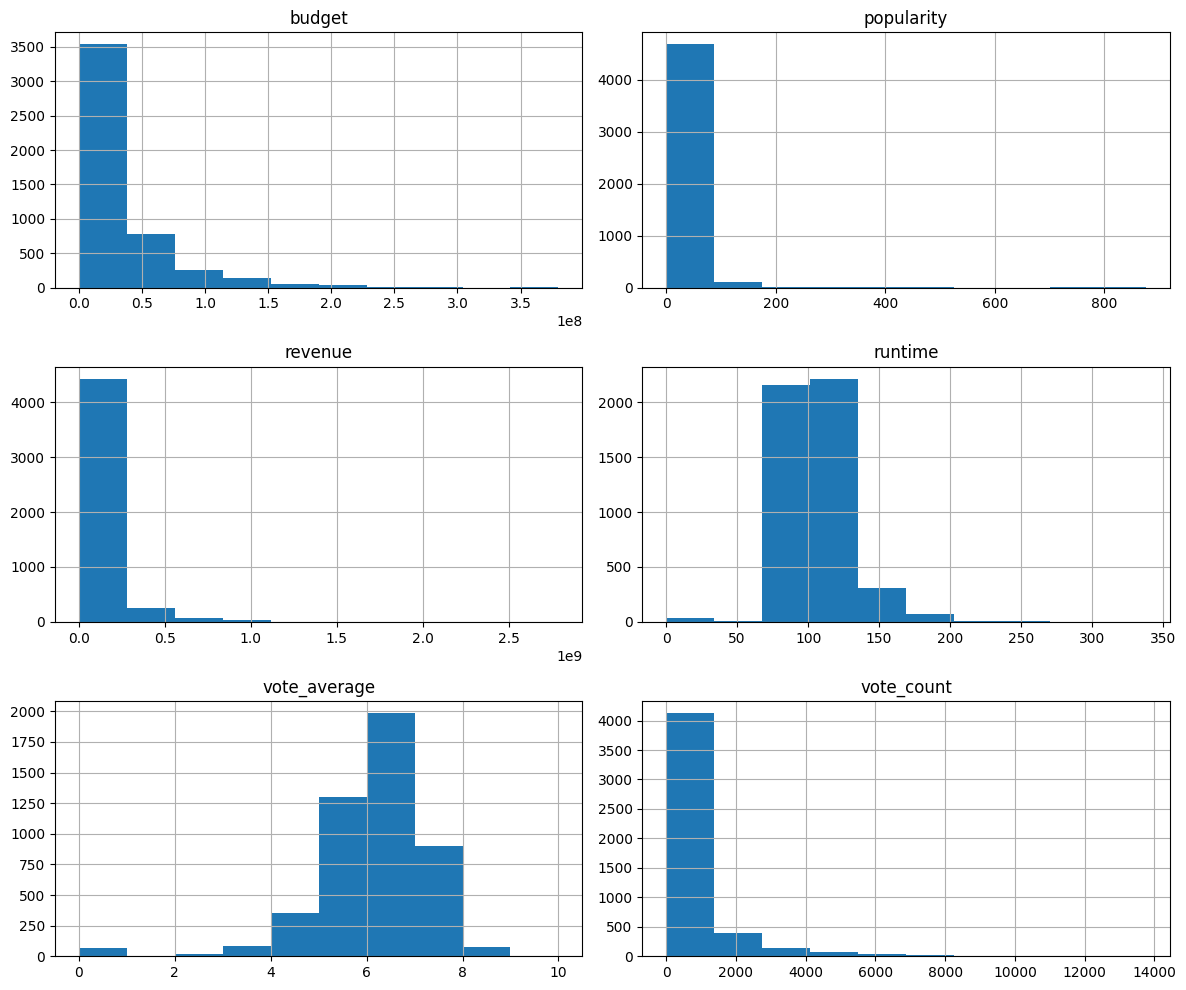

In [15]:
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.drop(
    "movie_id"
)
df[numerical_features].hist(figsize=(12, 10))

plt.tight_layout()
plt.show()

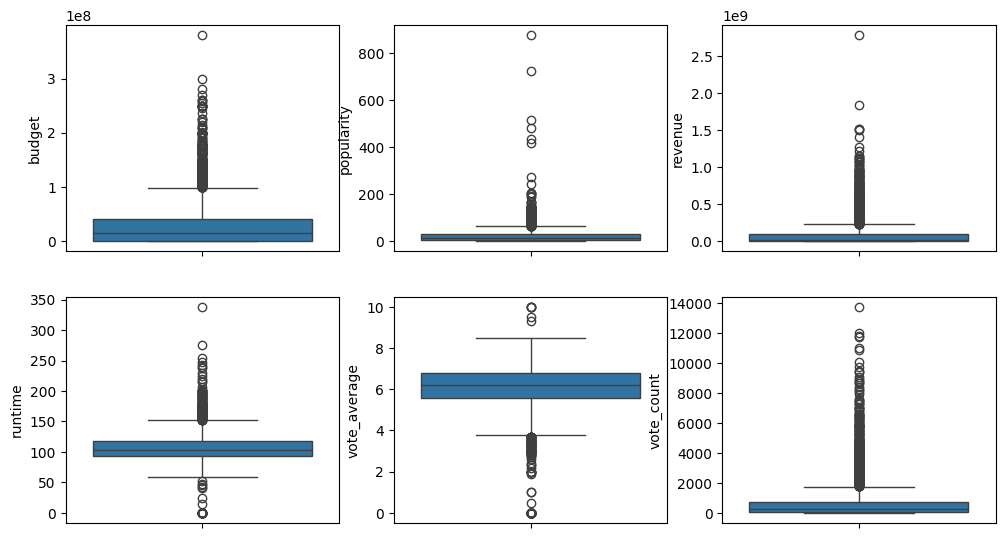

In [16]:
# Check for outliers
def check_for_outliers(df, columns):
    plt.figure(figsize=(12, 10))
    for i, column in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        sns.boxplot(df[column])


check_for_outliers(df, numerical_features)


# Remove outliers
def remove_outliers(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[column] > lower_bound) & (df[column] < upper_bound)]
    return df


# print(f'Shape before removing outliers: {df.shape}')
# df = remove_outliers(df, numerical_features)
# print(f'Shape after removing outliers: {df.shape}')
# check_for_outliers(df, numerical_features)

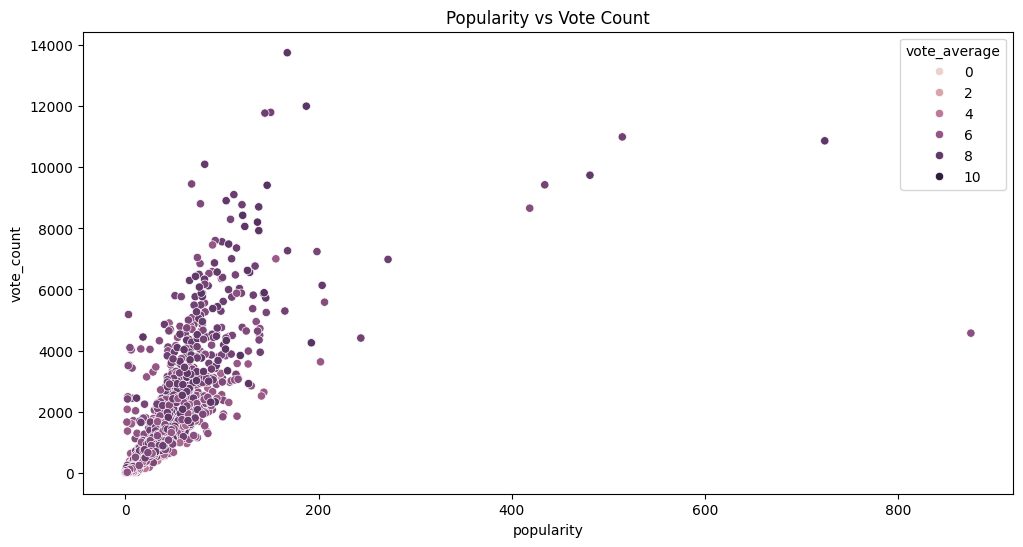

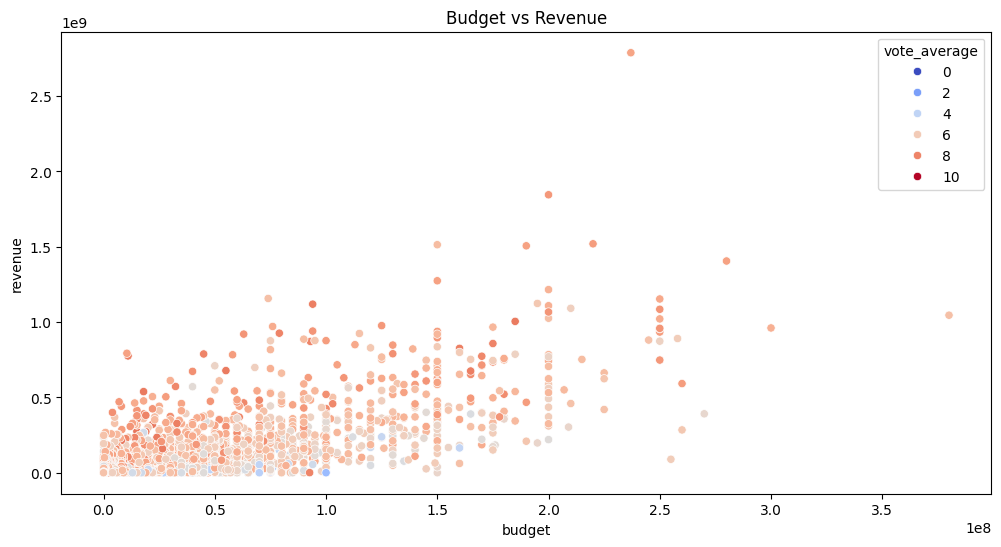

In [17]:
# Plot popularity vs vote_count
plt.figure(figsize=(12, 6))
sns.scatterplot(x="popularity", y="vote_count", data=df, hue="vote_average")
plt.title("Popularity vs Vote Count")
plt.show()

# Plot budget vs revenue
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="budget", y="revenue", data=df, hue="vote_average", palette="coolwarm"
)
plt.title("Budget vs Revenue")
plt.show()

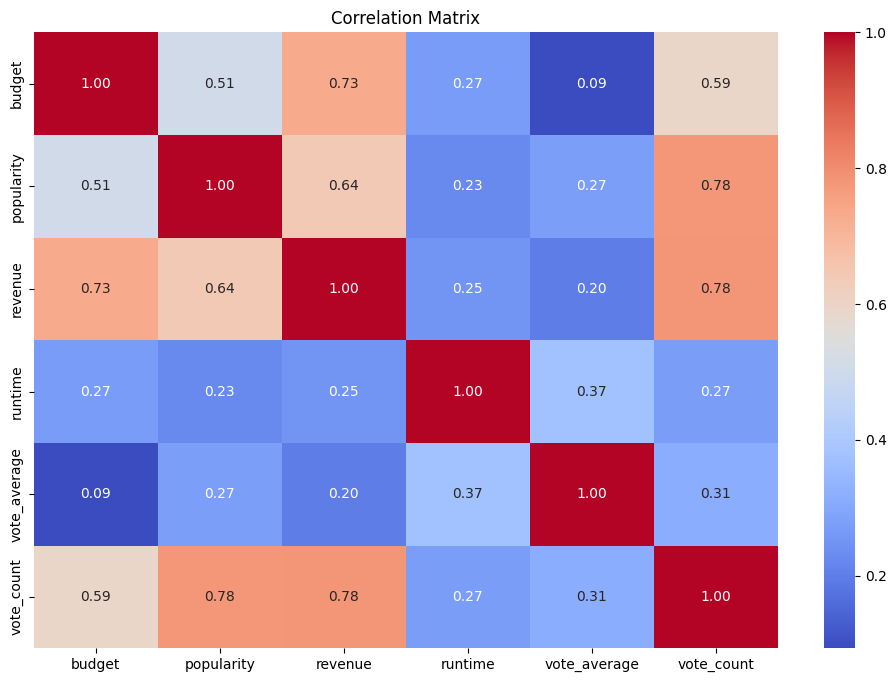

In [18]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## 4. Data Modeling (Using different ML models)


Add new features to the dataset which called 'profitable' and shows that if the movie revenue is greater than the budget or not.


In [19]:
# Add feature 'profitable'
df["profitable"] = df["revenue"] > df["budget"]

# How many movies are profitable?
df["profitable"].value_counts()

profitable
True     2585
False    2218
Name: count, dtype: int64

For feature selection as we use numerical models, we should use numerical features except for the 'review' feature. (profitable is true or false not numerical)


In [20]:
# Feature selection
# Select numerical features
column_X = (
    df.select_dtypes(include=["int64", "float64"])
    .drop(["movie_id", "revenue"], axis=1)
    .columns
)
print(column_X)

Index(['budget', 'popularity', 'runtime', 'vote_average', 'vote_count'], dtype='object')


Using our features to create X and profitable as y. Then split the data into train and test.


In [21]:
# Split the data into X and y
X = df[column_X]
y = df["profitable"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Since all the model has the same structure, we can use a for loop to train and test all the models. So I create a function which takes the model as input and returns statistics of the model and plot for ROC curve.


In [22]:
def analyze_model(model, X_train, y_train, X_test, y_test):
    # Start a timer
    start = time.time()
    print("\n", "=" * 50, sep="")
    print(model.__class__.__name__)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    roc_auc = round(roc_auc_score(y_test, y_pred_proba), 3)
    print("ROC AUC Score:", roc_auc)

    plt.plot([0, 1], [0, 1], "k--")
    plt.plot(fpr, tpr, label=model.__class__.__name__)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(model.__class__.__name__ + " ROC Curve")
    plt.show()

    print("Run Time:", round(time.time() - start, 2), "s")
    print("=" * 50, "\n")

    return accuracy, precision, recall, f1, roc_auc

I use the following models:

- Logistic Regression
- K-Nearest Neighbors
- Decision Tree
- Random Forest
- Gradient Boosting
- AdaBoost
- XGBoost
- Extra Trees

At the end, I compare the models and select the best model in a table.



LogisticRegression


Accuracy: 0.784
Precision: 0.844
Recall: 0.733
F1 Score: 0.785
ROC AUC Score: 0.846


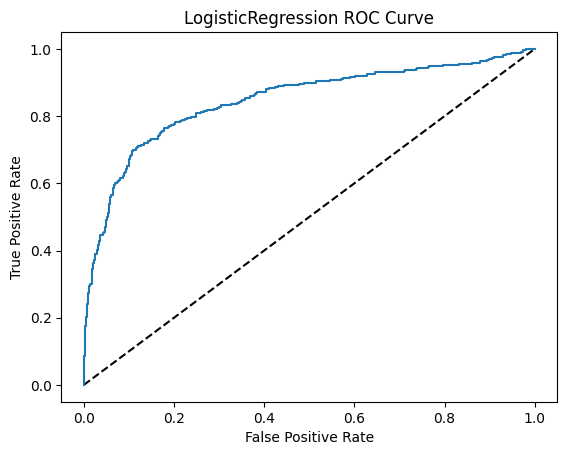

Run Time: 0.65 s


DecisionTreeClassifier
Accuracy: 0.717
Precision: 0.73
Recall: 0.752
F1 Score: 0.741
ROC AUC Score: 0.714


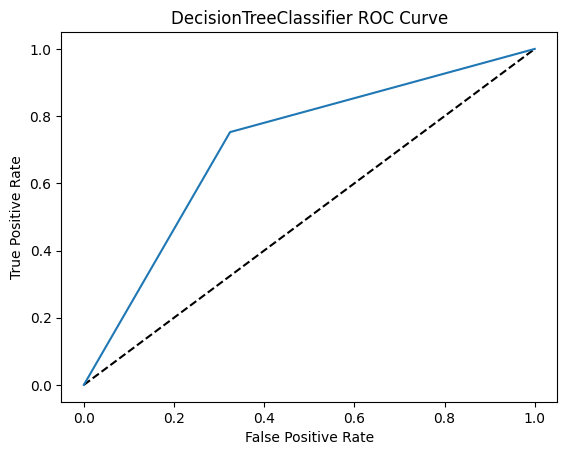

Run Time: 0.09 s


RandomForestClassifier
Accuracy: 0.789
Precision: 0.795
Recall: 0.818
F1 Score: 0.806
ROC AUC Score: 0.864


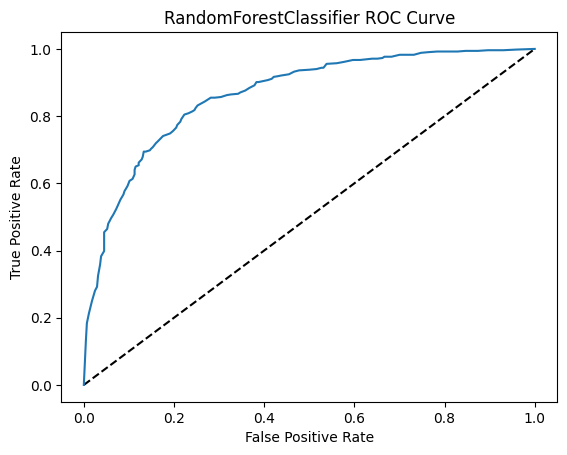

Run Time: 0.45 s


XGBClassifier
Accuracy: 0.78
Precision: 0.788
Recall: 0.81
F1 Score: 0.799
ROC AUC Score: 0.854


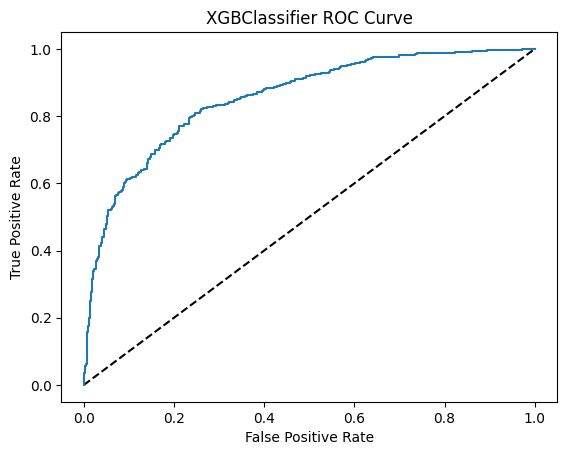

Run Time: 0.26 s


KNeighborsClassifier
Accuracy: 0.772
Precision: 0.773
Recall: 0.816
F1 Score: 0.794
ROC AUC Score: 0.823


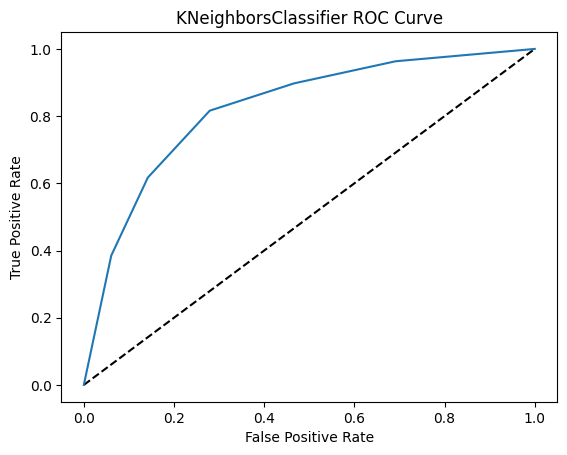

Run Time: 0.1 s


GradientBoostingClassifier
Accuracy: 0.793
Precision: 0.799
Recall: 0.822
F1 Score: 0.81
ROC AUC Score: 0.875


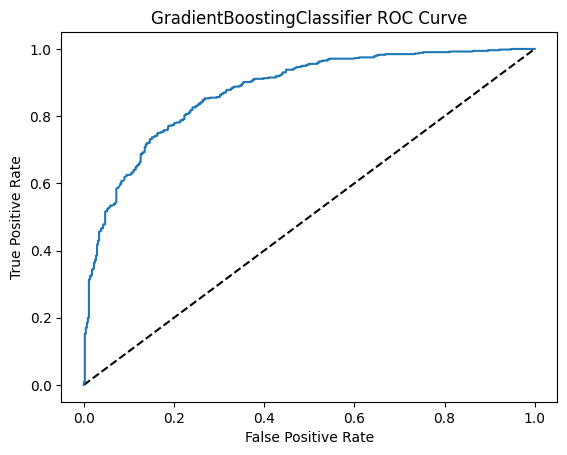

Run Time: 0.43 s


AdaBoostClassifier
Accuracy: 0.791
Precision: 0.799
Recall: 0.816
F1 Score: 0.808
ROC AUC Score: 0.867


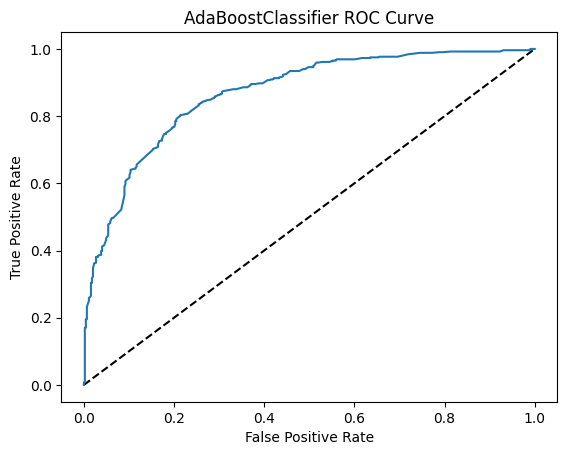

Run Time: 0.18 s


BaggingClassifier
Accuracy: 0.769
Precision: 0.796
Recall: 0.768
F1 Score: 0.781
ROC AUC Score: 0.834


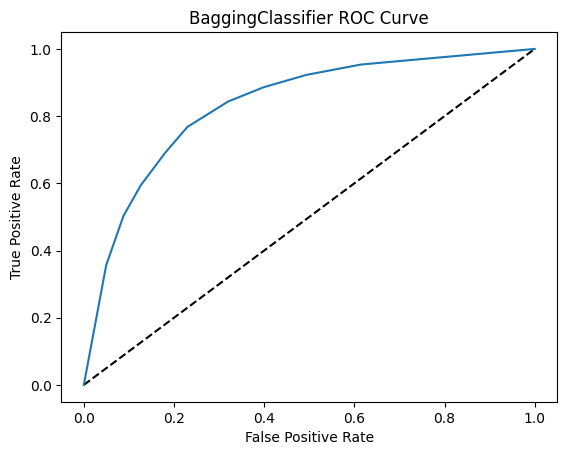

Run Time: 0.15 s


ExtraTreesClassifier
Accuracy: 0.783
Precision: 0.786
Recall: 0.818
F1 Score: 0.802
ROC AUC Score: 0.858


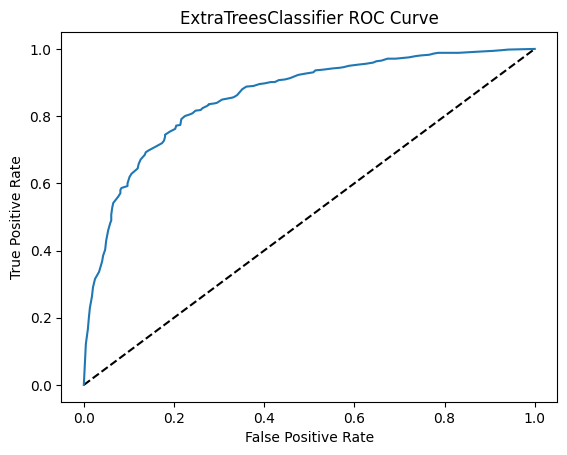

Run Time: 0.36 s



,Model,Accuracy,Precision,Recall,F1,ROC AUC
5,GradientBoostingClassifier,0.793,0.799,0.822,0.810,0.875
6,AdaBoostClassifier,0.791,0.799,0.816,0.808,0.867
2,RandomForestClassifier,0.789,0.795,0.818,0.806,0.864
8,ExtraTreesClassifier,0.783,0.786,0.818,0.802,0.858
3,XGBClassifier,0.780,0.788,0.810,0.799,0.854
0,LogisticRegression,0.784,0.844,0.733,0.785,0.846
7,BaggingClassifier,0.769,0.796,0.768,0.781,0.834
4,KNeighborsClassifier,0.772,0.773,0.816,0.794,0.823
1,DecisionTreeClassifier,0.717,0.730,0.752,0.741,0.714


In [23]:
# Test different models
# Logistic Regression, Decision Tree, Random Forest,
# XGBoost, KNN, Gradient Boosting, AdaBoost, Bagging, Extra Trees
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
]
analyzes = []
for model in models:
    accuracy, precision, recall, f1, roc_auc = analyze_model(
        model, X_train, y_train, X_test, y_test
    )
    analyzes.append(
        {
            "Model": model.__class__.__name__,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "ROC AUC": roc_auc,
        }
    )

# Print the results in a table
results = pd.DataFrame(analyzes).sort_values(by="ROC AUC", ascending=False)
results

Gradient Boosting is the best model with 0.8 accuracy and 0.87 AUC.


## 6. Recommender System


In [24]:
df.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[Action, Adventure, Fantasy, Science Fiction]","[Adventure, Fantasy, Action]","[Action, Adventure, Crime]","[Action, Crime, Drama, Thriller]","[Action, Adventure, Science Fiction]"
keywords,"[culture clash, future, space war, space colon...","[ocean, drug abuse, exotic island, east india ...","[spy, based on novel, secret agent, sequel, mi6]","[dc comics, crime fighter, terrorist, secret i...","[based on novel, mars, medallion, space travel..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.437577,139.082615,107.376788,112.31295,43.926995
production_companies,"[Ingenious Film Partners, Twentieth Century Fo...","[Walt Disney Pictures, Jerry Bruckheimer Films...","[Columbia Pictures, Danjaq, B24]","[Legendary Pictures, Warner Bros., DC Entertai...",[Walt Disney Pictures]
release_date,2009-12-10,2007-05-19,2015-10-26,2012-07-16,2012-03-07
revenue,2787965087,961000000,880674609,1084939099,284139100


Create a recommender system that recommends movies based on the user's input movie. The recommender system will use the cosine similarity to recommend the most similar movies to the user's input movie.


Use the following steps to create the recommender system:

- Create vectors for each movie based on the plot description (overview) and genre


Fiture we will use:

- Cast
- Crew
- Keywords
- Genre


In [25]:
df2 = df[["cast", "crew", "keywords", "genres"]]
df2.head()

,cast,crew,keywords,genres
0,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[James Cameron, James Cameron, Jon Landau]","[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]"
1,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Gore Verbinski, Jerry Bruckheimer, Eric McLeo...","[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]"
2,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Sam Mendes, Barbara Broccoli, Michael G. Wilson]","[spy, based on novel, secret agent, sequel, mi6]","[Action, Adventure, Crime]"
3,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Charles Roven, Christopher Nolan, Christopher...","[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]"
4,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Colin Wilson, Jim Morris, Lin...","[based on novel, mars, medallion, space travel...","[Action, Adventure, Science Fiction]"


Convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.


In [26]:
def change_names(s):
    # Check if the value is a list
    if isinstance(s, list):
        return [i.title().replace(" ", "") for i in s]
    # If the value is a string, return lower case and remove spaces
    elif isinstance(s, str):
        return s.lower().replace(" ", "")
    else:
        return ""


# Apply the function to your series
features = ["cast", "crew"]
for feature in features:
    df[feature] = df[feature].apply(change_names)

Create a metadata soup, which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director, keywords and genres).

Then create TfIdfVectorizer and fit and transform the metadata soup.


In [27]:
# Function to create a soup of features
def create_soup(x):
    return (
        " ".join(x["keywords"])
        + " "
        + " ".join(x["cast"])
        + " "
        + " ".join(x["crew"])
        + " "
        + " ".join(x["genres"])
    )


# Create the new soup feature
df2["soup"] = df2.apply(create_soup, axis=1)

# Display the soup of the first movie
print(df2.iloc[0]["soup"])

# Create a new TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english")

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2["soup"])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

culture clash future space war space colony society Sam Worthington Zoe Saldana Sigourney Weaver Stephen Lang Michelle Rodriguez James Cameron James Cameron Jon Landau Action Adventure Fantasy Science Fiction


(4803, 17392)

Then use the cosine_similarity to calculate the similarity between the movies.


In [28]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

Finally, create a function that takes in a movie title as an input and outputs a list of the 10 most similar movies.


In [29]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df["title_movies"]).drop_duplicates()


# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df["title_movies"].iloc[movie_indices]


# Get recommendations for The Godfather
get_recommendations("The Godfather")

2731     The Godfather: Part II
867     The Godfather: Part III
1525             Apocalypse Now
1167                    Dracula
4209           The Conversation
Name: title_movies, dtype: object

## The End

Thank you for your time. If you have any questions, please feel free to ask. I will be happy to help.
